In [1]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
import matplotlib.pyplot as plt
sys.path.append('../LIB/')
from env import ENV
from sklearn.preprocessing import normalize
from tqdm import tqdm
import pickle
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import gc

print_to_file = False 
test_run = False 

train = pd.read_pickle(ENV.lightgbm_train_764.value)
print('train shape is: {}'.format(train.shape))
test = pd.read_pickle(ENV.lightgbm_test_764.value)
print('test shape is: {}'.format(test.shape))
fe_id = 'comb_764'

train shape is: (307511, 764)
test shape is: (48744, 763)


In [2]:
train['SK_ID_CURR'] = train['SK_ID_CURR'].astype(int)
test['SK_ID_CURR'] = test['SK_ID_CURR'].astype(int)
targets = train.TARGET.values

In [3]:
train_id = train['SK_ID_CURR']
test_id = test['SK_ID_CURR']

# main func

In [4]:
from sklearn.model_selection import train_test_split

def get_time(timezone='America/New_York', time_format='%Y-%m-%d %H:%M:%S'):
    from datetime import datetime
    from dateutil import tz

    # METHOD 1: Hardcode zones:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(timezone)

    utc = datetime.utcnow()

    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)

    # Convert time zone
    est = utc.astimezone(to_zone)

    return est.strftime(time_format)

import sys, time
class Logger(object):
    def __init__(self, logtofile=True, logfilename='log'):
        self.terminal = sys.stdout
        self.logfile = "{}_{}.log".format(logfilename, int(time.time()))
        self.logtofile = logtofile

    def write(self, message):
        #         self.terminal.write(message)
        if self.logtofile:
            self.log = open(self.logfile, "a")
            self.log.write('[' + get_time() + '] ' + message)
            self.log.close()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass


def divert_printout_to_file():
    sys.stdout = Logger(logfilename='logfile')

if print_to_file:
    divert_printout_to_file()  # note: comment this to use pdb

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, train_df, test_df, holdout, num_folds, submission_file_name, fe_img_name, stratified = False, debug= False, colsample=0.67, max_depth=8, num_leaves=31, min_child_samples=20, subsample=0.7, reg_lambda=0.3, lr=0.04, seed=1001, verbose=100, rounds=None):
    print(train_df.shape, test_df.shape, holdout.shape)
    print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
    # Divide in training/validation and test data
    if df is not None:
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]
        print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    holdout_final_preds = np.zeros(holdout.shape[0])
    feature_importance_df = pd.DataFrame()
    feature_importance_gain_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_scores = []
    holdout_scores = []
    scores = []
    diff_val_holdout = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         print('valid index : ',list(valid_idx)[:5])
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
#         print('MEAN: train({}) vs valid({}): '.format(len(train_y), len(valid_y)), np.mean(train_y), np.mean(valid_y))

        clf = LGBMClassifier(
            nthread=18,
            n_estimators=30000,
            learning_rate=lr,
            num_leaves=num_leaves,
            colsample_bytree=colsample, # 0.67
            subsample=subsample,
            subsample_freq=0, ## disable subsampling
            max_depth=max_depth,
            reg_alpha=0.65,
            reg_lambda=reg_lambda,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            min_child_samples=min_child_samples,
            silent=-1,
            verbose=-1, )
        if rounds is not None:
            clf.n_estimators = rounds
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose=verbose)
            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
            holdout_preds = clf.predict_proba(holdout[feats])[:, 1] 
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose=verbose, early_stopping_rounds= 200)
            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
            holdout_preds = clf.predict_proba(holdout[feats], num_iteration=clf.best_iteration_)[:, 1] 
            
        holdout_final_preds += holdout_preds / folds.n_splits
        score = roc_auc_score(valid_y, oof_preds[valid_idx])
        train_score = clf.best_score_['training']['auc']
        holdout_score = roc_auc_score(holdout['TARGET'], holdout_preds)
        diff = abs(score - holdout_score)
        best_rounds = rounds if rounds is not None else clf.best_iteration_
        print('Fold %2d [%5d] AUC : ho: %.6f / te: %.6f / tr: %.6f (diff: %.6f)' % (n_fold + 1, best_rounds, holdout_score, score,  train_score, diff))
        scores.append(score)
        train_scores.append(train_score)
        holdout_scores.append(holdout_score)
        diff_val_holdout.append(diff)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        fold_importance_gain_df = pd.DataFrame()
        fold_importance_gain_df["feature"] = feats
        fold_importance_gain_df["importance"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance_gain_df["fold"] = n_fold + 1
        feature_importance_gain_df = pd.concat([feature_importance_gain_df, fold_importance_gain_df], axis=0)
        
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    holdout_roc = roc_auc_score(holdout['TARGET'], holdout_final_preds)
    holdout_mean = np.mean(holdout_scores)
    full_te_mean = np.mean(scores)
    full_tr_mean = np.mean(train_scores)
#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    print('Full HO score %.6f' % holdout_roc)
    print('FULL HO mean {:.6f}, std {:.6f}'.format(holdout_mean, np.std(holdout_scores)))
    print('FULL TE mean {:.6f}, std {:.6f}'.format(full_te_mean, np.std(scores)))
    print('FULL TR mean {:.6f}, std {:.6f}'.format(full_tr_mean, np.std(train_scores)))
    print('FULL DIFF mean {:.6f}, std {:.6f}'.format(np.mean(diff_val_holdout), np.std(diff_val_holdout)))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#     if not print_to_file:
#         display_importances(feature_importance_df, fe_img_name)
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    feature_importance_gain_df = feature_importance_gain_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    return feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds 

# Display/plot feature importance
def display_importances(feature_importance_df_, fe_img_name):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(fe_img_name+'.png')


def convert_and_save_imp_df(fe_imp_df, dumpfilename):
    fe_imp_df_mean = fe_imp_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    pickle.dump(fe_imp_df_mean, open(dumpfilename,'wb'))

In [5]:
def runlgb(train, test, holdout):
    colsamples = [0.07]#[0.1,0.15,0.2]#[0.03,0.04,0.05,0.06,0.07,0.08]
    seeds = [20]#[300,4000,50000,600000,7000000,80000000,523445,31275479] # 20
    depth = [5]
    leaves = [16]
    min_child_sam = [20]#, 800]
    subsamples = [1]#0.8, 0.7, 0.6, 0.5, 0.4] # was 1
    reg_lambdas = [0.5]
    # lrs = lrs.tolist()
    lrs2 = [0.005]
    nfolds = 5 
    rounds = [None] #[1000]#, 1300, 1600, 1900, 2200, 2500]
    for seed in seeds:
        for colsample in colsamples:
            for d in depth:
                for l in leaves:
                    for mcs in min_child_sam:
                        for subsample in subsamples:
                            for reg_lambda in reg_lambdas:
                                for lr in lrs2:
                                    for r in rounds:
                                        filename = 'fe_936_col{}_lr{}_n{}'.format(len(train.columns), lr, nfolds)
                                        print('#############################################')
                                        print(colsample, seed, d, l, mcs, subsample, reg_lambda, lr, 'nfolds:', nfolds)
                                        print('#############################################')
                                        numfeats = len(train.columns)
                                        with timer("Run LightGBM with kfold"):
                                            return kfold_lightgbm(None, train, test, holdout, nfolds, filename+'.csv', filename, colsample=colsample, verbose=None, max_depth=d, num_leaves=l, min_child_samples=mcs, subsample=subsample, reg_lambda=reg_lambda, lr=lr, seed=seed, stratified=True, rounds=r,debug=True)
    #                                         

# Drop columns

In [6]:
drop_columns = ['NAME_EDUCATION_TYPE_CODE_GENDER_AMT_CREDIT_mean_abs_diff','inst_DAYS_INSTALMENT_std']
train = train.drop(drop_columns,axis=1)
test = test.drop(drop_columns,axis=1)

In [7]:
train_df, holdout = train_test_split(train, test_size=1/7, random_state=x)
#42
print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
print(train_df.shape, test.shape, holdout.shape)

MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
(263580, 762) (48744, 761) (43931, 762)


# load_rnn

In [8]:
rnn_features = pd.read_pickle('../../data/rnn/rnn_all_features.pkl')

In [9]:
train_df = train_df.merge(rnn_features,how='left',left_on='SK_ID_CURR',right_on = 'SK_ID_CURR')
test = test.merge(rnn_features,how='left',left_on='SK_ID_CURR',right_on = 'SK_ID_CURR')
holdout = holdout.merge(rnn_features,how='left',left_on='SK_ID_CURR',right_on = 'SK_ID_CURR')

In [10]:
rnn_features_list = list(rnn_features.columns)

rnn_features_list.remove('SK_ID_CURR')
print(len(rnn_features_list))
holdout_roc_list = []
holdout_mean_list = []
full_te_mean_list = []
full_tr_mean_list = []
drop_list = []
for col in tqdm(['noadd']+rnn_features_list):
    print(col)
    if col == 'noadd':
        cols = list(set(rnn_features_list) - set([]))

        train_drop = train_df.drop(cols,axis=1)
        test_drop = test.drop(cols,axis=1)
        holdout_drop = holdout.drop(cols,axis=1)
       
    else:
        try:
            cols = list(set(rnn_features_list) - set([col]))

            train_drop = train_df.drop(cols,axis=1)
            test_drop = test.drop(cols,axis=1)
            holdout_drop = holdout.drop(cols,axis=1)
        except:
            continue
    feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout_drop)
    holdout_roc_list.append(holdout_roc)
    holdout_mean_list.append(holdout_mean)
    full_te_mean_list.append(full_te_mean)
    full_tr_mean_list.append(full_tr_mean)
    drop_list.append(col)
    gc.collect()
    
df_save = pd.DataFrame({'add_column':drop_list,
                        'holdout_roc':holdout_roc_list,
                        'holdout_mean':holdout_mean_list,
                        'full_te_mean':full_te_mean_list,
                        'full_tr_mean':full_tr_mean_list})
df_save.to_pickle('rnn_add_each.pkl')

  0%|          | 0/12 [00:00<?, ?it/s]

11
noadd
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 762) (48744, 761) (43931, 762)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [10076] AUC : ho: 0.799765 / te: 0.797569 / tr: 0.864415 (diff: 0.002196)
Fold  2 [10542] AUC : ho: 0.799414 / te: 0.795158 / tr: 0.867550 (diff: 0.004256)
Fold  3 [11460] AUC : ho: 0.799911 / te: 0.793394 / tr: 0.871988 (diff: 0.006517)
Fold  4 [10392] AUC : ho: 0.800736 / te: 0.797993 / tr: 0.865666 (diff: 0.002743)


  8%|▊         | 1/12 [11:53<2:10:53, 713.93s/it]

Fold  5 [ 9956] AUC : ho: 0.799269 / te: 0.794979 / tr: 0.863447 (diff: 0.004290)
Full HO score 0.801261
FULL HO mean 0.799819, std 0.000514
FULL TE mean 0.795818, std 0.001721
FULL TR mean 0.866613, std 0.003017
FULL DIFF mean 0.004001, std 0.001505
Run LightGBM with kfold - done in 713s
Wei_RNN_previous_application_v1
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [ 9633] AUC : ho: 0.799614 / te: 0.797906 / tr: 0.862330 (diff: 0.001708)
Fold  2 [ 8697] AUC : ho: 0.799380 / te: 0.795193 / tr: 0.857927 (diff: 0.004188)
Fold  3 [10586] AUC : ho: 0.800205 / te: 0.793406 / tr: 0.867576 (diff: 0.006799)
Fold  4 [ 9950] AUC : ho: 0.800192 / te: 0.798106 / tr: 0.863317 (diff: 0.002086)
Fold  5 [11941] AUC : ho: 0.799848 / te: 0.795674 / tr: 0.872801 (diff: 0.004174)
Full HO score 0.80

 17%|█▋        | 2/12 [23:34<1:57:52, 707.24s/it]

Wei_RNN_previous_application_v2
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [10375] AUC : ho: 0.800273 / te: 0.797856 / tr: 0.865744 (diff: 0.002416)
Fold  2 [10205] AUC : ho: 0.800383 / te: 0.795573 / tr: 0.865595 (diff: 0.004810)
Fold  3 [11510] AUC : ho: 0.800515 / te: 0.793507 / tr: 0.871805 (diff: 0.007008)
Fold  4 [ 7257] AUC : ho: 0.800123 / te: 0.797971 / tr: 0.848251 (diff: 0.002152)


 25%|██▌       | 3/12 [34:55<1:44:47, 698.56s/it]

Fold  5 [ 9719] AUC : ho: 0.799971 / te: 0.795038 / tr: 0.861846 (diff: 0.004933)
Full HO score 0.801652
FULL HO mean 0.800253, std 0.000191
FULL TE mean 0.795989, std 0.001712
FULL TR mean 0.862648, std 0.007874
FULL DIFF mean 0.004264, std 0.001797
Run LightGBM with kfold - done in 681s
Wei_RNN_bureau_v1
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [11244] AUC : ho: 0.800354 / te: 0.798908 / tr: 0.870422 (diff: 0.001446)
Fold  2 [ 8511] AUC : ho: 0.799632 / te: 0.795529 / tr: 0.857452 (diff: 0.004103)
Fold  3 [10180] AUC : ho: 0.800494 / te: 0.793763 / tr: 0.866038 (diff: 0.006730)
Fold  4 [ 9653] AUC : ho: 0.800605 / te: 0.798376 / tr: 0.862307 (diff: 0.002229)


 33%|███▎      | 4/12 [46:17<1:32:35, 694.46s/it]

Fold  5 [ 9626] AUC : ho: 0.799817 / te: 0.796179 / tr: 0.861928 (diff: 0.003638)
Full HO score 0.801552
FULL HO mean 0.800180, std 0.000385
FULL TE mean 0.796551, std 0.001889
FULL TR mean 0.863630, std 0.004353
FULL DIFF mean 0.003629, std 0.001820
Run LightGBM with kfold - done in 681s
Wei_RNN_bureau_v2
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [ 9720] AUC : ho: 0.799839 / te: 0.798043 / tr: 0.863187 (diff: 0.001795)
Fold  2 [ 8580] AUC : ho: 0.799661 / te: 0.795741 / tr: 0.857624 (diff: 0.003920)
Fold  3 [10085] AUC : ho: 0.800570 / te: 0.793611 / tr: 0.865929 (diff: 0.006959)
Fold  4 [10010] AUC : ho: 0.800735 / te: 0.798483 / tr: 0.864212 (diff: 0.002251)


 42%|████▏     | 5/12 [58:00<1:21:12, 696.02s/it]

Fold  5 [12619] AUC : ho: 0.799943 / te: 0.796588 / tr: 0.876728 (diff: 0.003356)
Full HO score 0.801561
FULL HO mean 0.800150, std 0.000424
FULL TE mean 0.796493, std 0.001746
FULL TR mean 0.865536, std 0.006249
FULL DIFF mean 0.003656, std 0.001817
Run LightGBM with kfold - done in 702s
Wei_RNN_installment_v1
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [10097] AUC : ho: 0.799770 / te: 0.797796 / tr: 0.864567 (diff: 0.001974)
Fold  2 [ 9692] AUC : ho: 0.799891 / te: 0.794870 / tr: 0.863059 (diff: 0.005021)
Fold  3 [10140] AUC : ho: 0.799920 / te: 0.793309 / tr: 0.865428 (diff: 0.006610)
Fold  4 [ 7393] AUC : ho: 0.799708 / te: 0.797844 / tr: 0.849367 (diff: 0.001864)
Fold  5 [10129] AUC : ho: 0.799770 / te: 0.795358 / tr: 0.864177 (diff: 0.004412)
Full HO score 0.801164
FULL

 50%|█████     | 6/12 [1:08:59<1:08:59, 689.90s/it]

Wei_RNN_installment_v2
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [ 9849] AUC : ho: 0.799505 / te: 0.797880 / tr: 0.863411 (diff: 0.001626)
Fold  2 [ 9751] AUC : ho: 0.799450 / te: 0.795205 / tr: 0.863270 (diff: 0.004246)
Fold  3 [12522] AUC : ho: 0.800041 / te: 0.793623 / tr: 0.876954 (diff: 0.006418)
Fold  4 [ 7934] AUC : ho: 0.799836 / te: 0.797613 / tr: 0.852363 (diff: 0.002224)


 58%|█████▊    | 7/12 [1:20:22<57:24, 688.99s/it]  

Fold  5 [ 9518] AUC : ho: 0.799583 / te: 0.794968 / tr: 0.861088 (diff: 0.004615)
Full HO score 0.801099
FULL HO mean 0.799683, std 0.000222
FULL TE mean 0.795858, std 0.001636
FULL TR mean 0.863417, std 0.007885
FULL DIFF mean 0.003825, std 0.001728
Run LightGBM with kfold - done in 683s
Wei_RNN_creditcard_v1
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [10865] AUC : ho: 0.799686 / te: 0.798080 / tr: 0.868632 (diff: 0.001606)
Fold  2 [ 9710] AUC : ho: 0.799425 / te: 0.795422 / tr: 0.863263 (diff: 0.004004)
Fold  3 [10660] AUC : ho: 0.799839 / te: 0.793579 / tr: 0.868136 (diff: 0.006261)
Fold  4 [ 9333] AUC : ho: 0.800219 / te: 0.797927 / tr: 0.860351 (diff: 0.002292)
Fold  5 [ 8976] AUC : ho: 0.799074 / te: 0.795202 / tr: 0.858371 (diff: 0.003872)
Full HO score 0.801032
FULL 

 67%|██████▋   | 8/12 [1:31:46<45:53, 688.33s/it]

Wei_RNN_creditcard_v2
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [11029] AUC : ho: 0.799428 / te: 0.797897 / tr: 0.869391 (diff: 0.001532)
Fold  2 [10060] AUC : ho: 0.799606 / te: 0.795093 / tr: 0.865094 (diff: 0.004513)
Fold  3 [ 9358] AUC : ho: 0.799587 / te: 0.793007 / tr: 0.861441 (diff: 0.006579)
Fold  4 [ 9802] AUC : ho: 0.800370 / te: 0.797702 / tr: 0.862415 (diff: 0.002667)


 75%|███████▌  | 9/12 [1:43:14<34:24, 688.25s/it]

Fold  5 [ 9653] AUC : ho: 0.799246 / te: 0.795104 / tr: 0.861731 (diff: 0.004142)
Full HO score 0.801055
FULL HO mean 0.799647, std 0.000384
FULL TE mean 0.795761, std 0.001832
FULL TR mean 0.864014, std 0.002982
FULL DIFF mean 0.003887, std 0.001717
Run LightGBM with kfold - done in 687s
Wei_RNN_main_plain_v1
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [    1] AUC : ho: 0.782216 / te: 0.781403 / tr: 0.781632 (diff: 0.000813)
Fold  2 [    1] AUC : ho: 0.782657 / te: 0.780210 / tr: 0.782739 (diff: 0.002448)
Fold  3 [    1] AUC : ho: 0.781873 / te: 0.775428 / tr: 0.783451 (diff: 0.006445)
Fold  4 [    1] AUC : ho: 0.782102 / te: 0.786072 / tr: 0.781370 (diff: 0.003970)


 83%|████████▎ | 10/12 [1:44:14<20:50, 625.44s/it]

Fold  5 [    1] AUC : ho: 0.783165 / te: 0.781583 / tr: 0.781945 (diff: 0.001581)
Full HO score 0.784850
FULL HO mean 0.782403, std 0.000459
FULL TE mean 0.780939, std 0.003402
FULL TR mean 0.782227, std 0.000765
FULL DIFF mean 0.003051, std 0.001995
Run LightGBM with kfold - done in 59s
Wei_RNN_main_plain_v2
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [    1] AUC : ho: 0.780162 / te: 0.780927 / tr: 0.781172 (diff: 0.000765)
Fold  2 [    1] AUC : ho: 0.776915 / te: 0.776722 / tr: 0.779200 (diff: 0.000193)
Fold  3 [    1] AUC : ho: 0.779817 / te: 0.774439 / tr: 0.782616 (diff: 0.005378)
Fold  4 [    1] AUC : ho: 0.779685 / te: 0.783582 / tr: 0.780610 (diff: 0.003897)


 92%|█████████▏| 11/12 [1:45:14<09:34, 574.04s/it]

Fold  5 [    1] AUC : ho: 0.777906 / te: 0.779534 / tr: 0.779144 (diff: 0.001628)
Full HO score 0.781513
FULL HO mean 0.778897, std 0.001263
FULL TE mean 0.779041, std 0.003193
FULL TR mean 0.780548, std 0.001301
FULL DIFF mean 0.002372, std 0.001962
Run LightGBM with kfold - done in 59s
Wei_RNN_main_ALL_v1
#############################################
0.07 20 5 16 20 1 0.5 0.005 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08082555580848319 0.08014841455919511
Fold  1 [    1] AUC : ho: 0.780063 / te: 0.781122 / tr: 0.780574 (diff: 0.001059)
Fold  2 [    1] AUC : ho: 0.781071 / te: 0.779124 / tr: 0.782191 (diff: 0.001947)
Fold  3 [    1] AUC : ho: 0.779965 / te: 0.775154 / tr: 0.782527 (diff: 0.004811)
Fold  4 [    1] AUC : ho: 0.781270 / te: 0.784378 / tr: 0.780216 (diff: 0.003108)


100%|██████████| 12/12 [1:46:15<00:00, 531.25s/it]

Fold  5 [    1] AUC : ho: 0.780345 / te: 0.782074 / tr: 0.780845 (diff: 0.001729)
Full HO score 0.781953
FULL HO mean 0.780543, std 0.000531
FULL TE mean 0.780370, std 0.003108
FULL TR mean 0.781271, std 0.000917
FULL DIFF mean 0.002531, std 0.001318
Run LightGBM with kfold - done in 60s


In [11]:
df_save

,add_column,holdout_roc,holdout_mean,full_te_mean,full_tr_mean
0,noadd,0.801261,0.799819,0.795818,0.866613
1,Wei_RNN_previous_application_v1,0.801257,0.799848,0.796057,0.864790
2,Wei_RNN_previous_application_v2,0.801652,0.800253,0.795989,0.862648
3,Wei_RNN_bureau_v1,0.801552,0.800180,0.796551,0.863630
4,Wei_RNN_bureau_v2,0.801561,0.800150,0.796493,0.865536
5,Wei_RNN_installment_v1,0.801164,0.799812,0.795836,0.861320
6,Wei_RNN_installment_v2,0.801099,0.799683,0.795858,0.863417
7,Wei_RNN_creditcard_v1,0.801032,0.799649,0.796042,0.863751
8,Wei_RNN_creditcard_v2,0.801055,0.799647,0.795761,0.864014
9,Wei_RNN_main_plain_v1,0.784850,0.782403,0.780939,0.782227


In [13]:
df_save

,add_column,holdout_roc,holdout_mean,full_te_mean,full_tr_mean
0,noadd,0.799769,0.795294,0.792078,0.863007
1,Wei_RNN_previous_application_v1,0.799161,0.795043,0.791800,0.858155
2,Wei_RNN_previous_application_v2,0.799716,0.795565,0.792195,0.861242
3,Wei_RNN_bureau_v1,0.800022,0.796103,0.792424,0.858699
4,Wei_RNN_bureau_v2,0.800372,0.796130,0.792217,0.861843
5,Wei_RNN_installment_v1,0.799384,0.795233,0.791359,0.858220
6,Wei_RNN_installment_v2,0.798691,0.794538,0.791844,0.860209
7,Wei_RNN_creditcard_v1,0.799245,0.794902,0.791997,0.861873
8,Wei_RNN_creditcard_v2,0.798325,0.793848,0.791470,0.862088
9,Wei_RNN_main_plain_v1,0.797322,0.794921,0.792098,0.830939


In [13]:
 feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 773) (48744, 772) (43931, 773)
MEAN: train(263580) vs holdout(43931):  0.08082934972304423 0.0801256515899934
Fold  1 [  238] AUC : ho: 0.793838 / te: 0.792083 / tr: 0.831622 (diff: 0.001755)
Fold  2 [  388] AUC : ho: 0.793349 / te: 0.793344 / tr: 0.851183 (diff: 0.000005)
Fold  3 [  328] AUC : ho: 0.793422 / te: 0.793318 / tr: 0.843444 (diff: 0.000104)
Fold  4 [  257] AUC : ho: 0.794674 / te: 0.796541 / tr: 0.833463 (diff: 0.001868)
Full HO score 0.796158
FULL HO mean 0.793821, std 0.000527
FULL TE mean 0.793821, std 0.001651
FULL TR mean 0.839928, std 0.007903
FULL DIFF mean 0.000933, std 0.000880
Run LightGBM with kfold - done in 73s


In [10]:
 feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.08078002883375067 0.08042157018961553
Fold  1 [  484] AUC : ho: 0.793277 / te: 0.788727 / tr: 0.864418 (diff: 0.004551)
Fold  2 [  463] AUC : ho: 0.792991 / te: 0.791373 / tr: 0.860757 (diff: 0.001618)
Fold  3 [  453] AUC : ho: 0.791847 / te: 0.794854 / tr: 0.859267 (diff: 0.003008)
Fold  4 [  370] AUC : ho: 0.792858 / te: 0.794930 / tr: 0.850584 (diff: 0.002072)
Full HO score 0.796783
FULL HO mean 0.792743, std 0.000539
FULL TE mean 0.792471, std 0.002596
FULL TR mean 0.858757, std 0.005077
FULL DIFF mean 0.002812, std 0.001122
Run LightGBM with kfold - done in 68s


In [45]:
df_save[df_save.drop_column == 'nodrop']

,drop_column,holdout_roc,holdout_mean,full_te_mean,full_tr_mean
761,nodrop,0.798539,0.794184,0.792477,0.86322


In [46]:
df_save.sort_values('full_te_mean',ascending=False)

,drop_column,holdout_roc,holdout_mean,full_te_mean,full_tr_mean
724,creditcard_AMT_CREDIT_LIMIT_ACTUAL_divide_CNT_...,0.796593,0.792020,0.793088,0.872096
292,prev_AMT_CREDIT_divide_DAYS_LAST_DUE_1ST_VERSI...,0.797061,0.793155,0.792986,0.860162
285,APARTMENTS_AVG_x,0.796835,0.792638,0.792917,0.867270
349,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,0.796366,0.792136,0.792894,0.867020
706,bureau_AMT_CREDIT_SUM_divide_AMT_ANNUITY_mean,0.796871,0.792594,0.792890,0.866289
757,last_5_installment_paid_over_amount_iqr,0.796485,0.792393,0.792880,0.863577
282,REFUSED_DAYS_DECISION_MIN,0.796460,0.792305,0.792873,0.866308
338,REFUSED_AMT_ANNUITY_MIN,0.795924,0.791495,0.792832,0.868395
33,last_5by20_fraction_installment_paid_late_in_d...,0.797132,0.792765,0.792829,0.868517
141,bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_LI...,0.797310,0.793204,0.792819,0.864957


In [31]:
df_save.sort_values('full_te_mean',ascending=False)

,drop_column,holdout_roc,holdout_mean,full_te_mean,full_tr_mean
724,creditcard_AMT_CREDIT_LIMIT_ACTUAL_divide_CNT_...,0.796593,0.792020,0.793088,0.872096
292,prev_AMT_CREDIT_divide_DAYS_LAST_DUE_1ST_VERSI...,0.797061,0.793155,0.792986,0.860162
285,APARTMENTS_AVG_x,0.796835,0.792638,0.792917,0.867270
349,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,0.796366,0.792136,0.792894,0.867020
706,bureau_AMT_CREDIT_SUM_divide_AMT_ANNUITY_mean,0.796871,0.792594,0.792890,0.866289
757,last_5_installment_paid_over_amount_iqr,0.796485,0.792393,0.792880,0.863577
282,REFUSED_DAYS_DECISION_MIN,0.796460,0.792305,0.792873,0.866308
338,REFUSED_AMT_ANNUITY_MIN,0.795924,0.791495,0.792832,0.868395
33,last_5by20_fraction_installment_paid_late_in_d...,0.797132,0.792765,0.792829,0.868517
141,bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_LI...,0.797310,0.793204,0.792819,0.864957


# View report

In [12]:
report = pd.read_pickle('dropEachColumnsReport.pkl')

## Get threads

In [13]:
col_name,thred_hroc,thred_hmean,thred_fulltemean,threa_tr_mean= list(report[report.drop_column=='nodrop'].values[0])

## holdout roc increased

In [14]:
sum(report.holdout_roc > thred_hroc)

208

## holdout_mean increased number

In [15]:
sum(report.holdout_mean > thred_hmean)

122

### full test mean get increased number

In [16]:
sum(report.full_te_mean > thred_fulltemean)

47

### all increased

In [17]:
print(sum((report.full_te_mean > thred_fulltemean) & (report.holdout_mean > thred_hmean) & (report.holdout_roc > thred_hroc)))

18


In [19]:
df_all_increase = report[(report.full_te_mean > thred_fulltemean) & (report.holdout_mean > thred_hmean) & (report.holdout_roc > thred_hroc)].copy()

In [20]:
df_all_increase.sort_values('holdout_roc',ascending=False)

,drop_column,holdout_roc,holdout_mean,full_te_mean,full_tr_mean
31,NAME_EDUCATION_TYPE_CODE_GENDER_AMT_CREDIT_mea...,0.798539,0.794184,0.792477,0.863220
21,ACTIVE_DAYS_CREDIT_MAX,0.798284,0.793837,0.792306,0.866758
18,bureau_agg__AMT_CREDIT_SUM_divide_DAYS_CREDIT_...,0.798258,0.793843,0.792409,0.867153
26,CNT_INSTALMENT_FUTURE_mean,0.798132,0.794109,0.792379,0.860614
35,inst_RATE_RATE_LATE_PAYMENT_mean,0.798117,0.794016,0.792228,0.858904
16,NAME_EDUCATION_TYPE_CODE_GENDER_DAYS_EMPLOYED_...,0.798058,0.793893,0.792180,0.862694
62,AMT_CREDIT_divide_DAYS_BIRTH,0.798001,0.793658,0.792193,0.864625
27,pos_cash_remaining_installments,0.797968,0.793580,0.792217,0.863159
12,NAME_FAMILY_STATUS_NAME_EDUCATION_TYPE_AMT_ANN...,0.797916,0.793719,0.792186,0.858426
103,PREV_NAME_YIELD_GROUP_high_MEAN,0.797915,0.793606,0.792206,0.863619


In [21]:
report.sort_values('holdout_roc',ascending=False)

,drop_column,holdout_roc,holdout_mean,full_te_mean,full_tr_mean
31,NAME_EDUCATION_TYPE_CODE_GENDER_AMT_CREDIT_mea...,0.798539,0.794184,0.792477,0.863220
8,EXT_SOURCE_3_x,0.798506,0.794082,0.791295,0.863029
11,EXT_SOURCE_1_x,0.798429,0.793791,0.791510,0.867987
40,REGION_POPULATION_RELATIVE_x,0.798422,0.794243,0.791665,0.859342
60,YEARS_BEGINEXPLUATATION_AVG_x,0.798341,0.793854,0.791665,0.866468
7,EXT_SOURCE_2_x,0.798332,0.793578,0.791440,0.869956
14,bureau_debt_credit_ratio,0.798308,0.794013,0.791796,0.863911
50,NAME_EDUCATION_TYPE_CODE_GENDER_DAYS_BIRTH_mea...,0.798287,0.793279,0.792042,0.874419
21,ACTIVE_DAYS_CREDIT_MAX,0.798284,0.793837,0.792306,0.866758
63,REFUSED_DAYS_DECISION_MAX,0.798278,0.793675,0.791634,0.869151


# Experiment

In [19]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 764) (48744, 764) (43931, 764)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  528] AUC : ho: 0.792890 / te: 0.793603 / tr: 0.867796 (diff: 0.000713)
Fold  2 [  434] AUC : ho: 0.793506 / te: 0.791989 / tr: 0.857608 (diff: 0.001517)
Fold  3 [  561] AUC : ho: 0.792675 / te: 0.794414 / tr: 0.870024 (diff: 0.001739)
Fold  4 [  415] AUC : ho: 0.793564 / te: 0.788659 / tr: 0.855359 (diff: 0.004905)
Full HO score 0.797207
FULL HO mean 0.793159, std 0.000385
FULL TE mean 0.792166, std 0.002205
FULL TR mean 0.862697, std 0.006313
FULL DIFF mean 0.002219, std 0.001597
Run LightGBM with kfold - done in 70s


In [18]:
res = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(263580, 764) (48744, 764) (43931, 764)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  795] AUC : ho: 0.794584 / te: 0.795493 / tr: 0.852858 (diff: 0.000909)
Fold  2 [ 1078] AUC : ho: 0.795753 / te: 0.795111 / tr: 0.865921 (diff: 0.000642)
Fold  3 [ 1160] AUC : ho: 0.795761 / te: 0.792183 / tr: 0.871919 (diff: 0.003578)
Fold  4 [ 1251] AUC : ho: 0.795716 / te: 0.800059 / tr: 0.874186 (diff: 0.004342)
Fold  5 [ 1175] AUC : ho: 0.795232 / te: 0.790522 / tr: 0.873062 (diff: 0.004710)
Full HO score 0.798031
FULL HO mean 0.795409, std 0.000458
FULL TE mean 0.794674, std 0.003265
FULL TR mean 0.867589, std 0.007899
FULL DIFF mean 0.002836, std 0.001724
Run LightGBM with kfold - done in 124s


In [38]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    if not print_to_file:
        plt.rcParams['font.size'] = 18
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(df.index[:15]))), 
                df['importance_normalized'].head(15), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(df.index[:15]))))
        ax.set_yticklabels(df['feature'].head(15))

        # Plot labeling
        plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
        plt.title('Cumulative Feature Importance');
        plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [39]:
split_imp, gain_imp, _ = res 

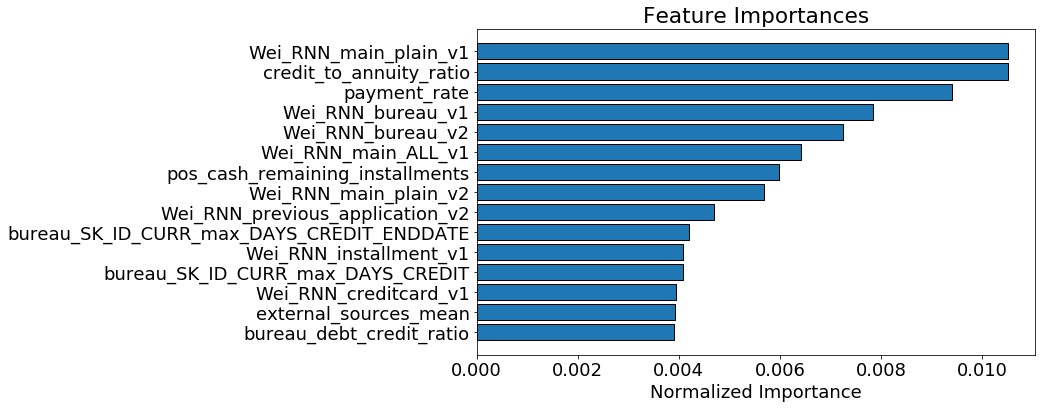

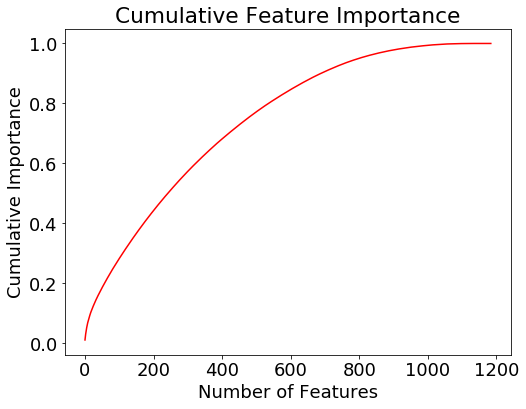

690 features required for 0.90 of cumulative importance


In [234]:
# feature_importances = pickle.load(open('../selection_comb_bo2_op5f4_simfe/fe_imp_corr_nan_df.pkl','rb'))
split_norm_fe_imp = plot_feature_importances(split_imp)

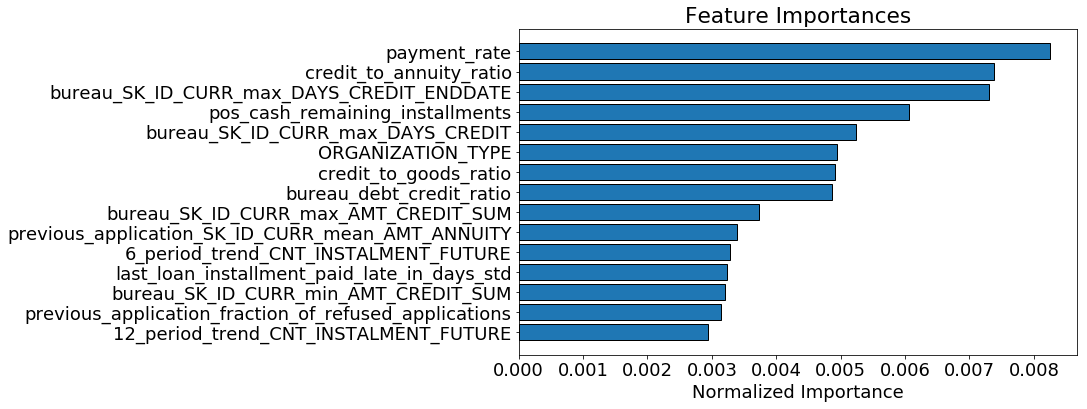

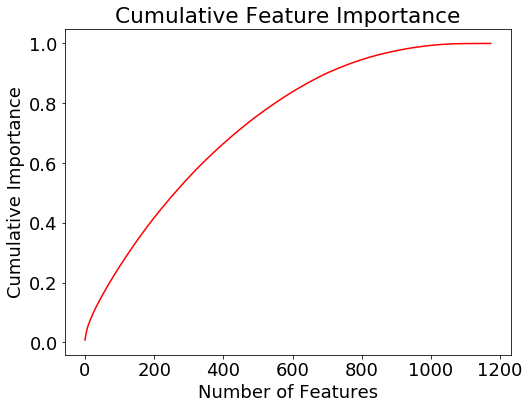

699 features required for 0.90 of cumulative importance


In [207]:
# feature_importances = pickle.load(open('../selection_comb_bo2_op5f4_simfe/fe_imp_corr_nan_df.pkl','rb'))
split_norm_fe_imp = plot_feature_importances(split_imp)